R09 3


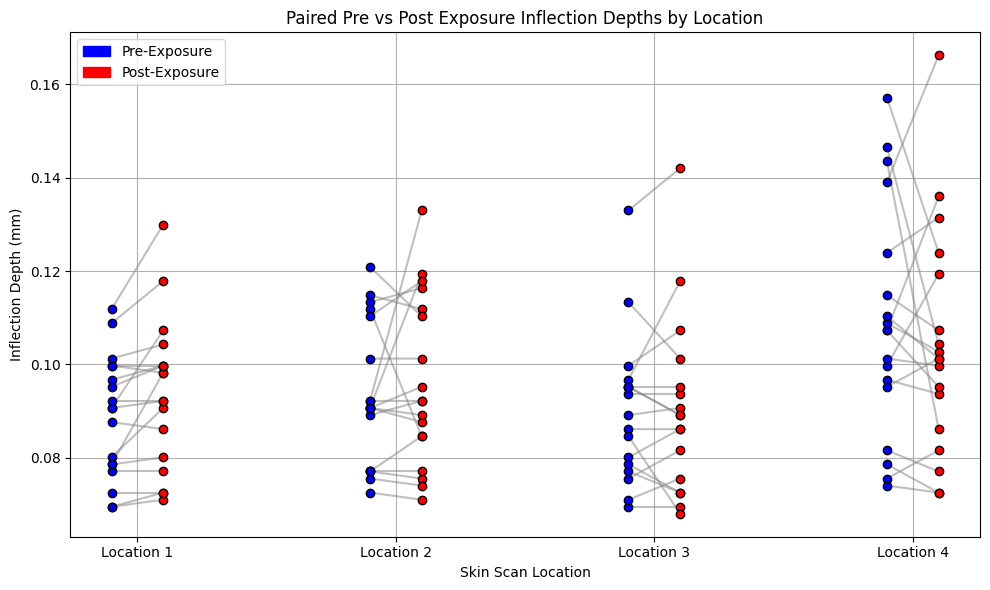

In [3]:
import data_read
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Function to remove outliers from a list using the IQR method
def remove_outliers(data):
    if len(data) < 4:
        return data  # Not enough points for IQR
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [x for x in data if lower <= x <= upper]

# Initialize per-subject per-location storage
subject_pre_data = {}   # {subject_id: {location: [depths]}}
subject_post_data = {}

vivosight_folder = "data/Vivosight_data/"
scan_folder = "data/scan_information/"
subject_ids = data_read.get_all_subject_ids(vivosight_folder)

# Collect scan data
for subject_id in subject_ids:
    subject_data = data_read.process_subject_vivosight_data(subject_id, vivosight_folder, scan_folder, "epidermal")

    if subject_id not in subject_pre_data:
        subject_pre_data[subject_id] = {1: [], 2: [], 3: [], 4: []}
        subject_post_data[subject_id] = {1: [], 2: [], 3: [], 4: []}

    for derm_scan in subject_data.visit.epidermal:
        derm_scan.get_normalize_a_scan()
        if derm_scan.location not in [1, 2, 3, 4]:
            continue

        derm_scan.approach_1(15)
        if derm_scan.min_location_index is None:
            derm_scan.approach_2(15, 200)

        if derm_scan.min_location_index is None:
            continue

        inflection_depth = derm_scan.depth_data["Depth"][derm_scan.min_location_index]

        if derm_scan.exposed:
            subject_post_data[subject_id][derm_scan.location].append(inflection_depth)
        else:
            subject_pre_data[subject_id][derm_scan.location].append(inflection_depth)

# Plotting all locations on one plot
plt.figure(figsize=(10, 6))

for loc in [1, 2, 3, 4]:
    for subject_id in subject_ids:
        pre_vals = remove_outliers(subject_pre_data.get(subject_id, {}).get(loc, []))
        post_vals = remove_outliers(subject_post_data.get(subject_id, {}).get(loc, []))

        if pre_vals and post_vals:
            avg_pre = np.mean(pre_vals)
            avg_post = np.mean(post_vals)
            if avg_post > 0.3:
                print(subject_id,loc)
                continue

            x_vals = [loc - 0.1, loc + 0.1]
            y_vals = [avg_pre, avg_post]

            # Line
            plt.plot(x_vals, y_vals, color='gray', alpha=0.5)

            # Dots
            plt.scatter(loc - 0.1, avg_pre, color='blue', edgecolor='black', zorder=3)
            plt.scatter(loc + 0.1, avg_post, color='red', edgecolor='black', zorder=3)

# Legend
blue_patch = mpatches.Patch(color='blue', label='Pre-Exposure')
red_patch = mpatches.Patch(color='red', label='Post-Exposure')
plt.legend(handles=[blue_patch, red_patch], loc='upper left')

# Labeling
plt.xticks([1, 2, 3, 4], [f"Location {i}" for i in range(1, 5)])
plt.xlabel("Skin Scan Location")
plt.ylabel("Inflection Depth (mm)")
plt.title("Paired Pre vs Post Exposure Inflection Depths by Location")
plt.grid(True)
plt.tight_layout()
plt.show()